In [1]:
from main import *
from visualization import *
from stats import *

from tqdm import tqdm

%matplotlib inline
plt.rcParams['font.size'] = 18

# Part 1: Various fingerprinting approaches

In [2]:
def fingerprint_matrices(m1, m2, method='corr', return_symmetrical=True):
    matrix = np.zeros((m1.shape[0], m2.shape[0]))
    for i in range(m1.shape[0]):
        for j in range(m1.shape[0]):
            triangle = np.triu_indices(m1.shape[1], 1)
            matrix[i, j] = pearsonr(m1[i][triangle], m2[j][triangle])[0]
    matrix_sym = 0.5 * (matrix + matrix.T)
    most_similar = np.zeros((matrix.shape[0], matrix.shape[0]))
    for i in range(matrix.shape[0]):
        most_similar[i, :] = matrix_sym[i, :] == np.max(matrix_sym[i, :])
    return matrix, most_similar

def fingerprint_vectors(v1, v2, method='corr', return_symmetrical=True):
    matrix = np.zeros((v1.shape[0], v1.shape[0]))
    for i in range(v1.shape[0]):
        for j in range(v1.shape[0]):
            if method == 'corr':
                matrix[i, j] = pearsonr(v1[i], v2[j])[0]
            elif method == 'euc':
                matrix[i, j] = 1 / np.sqrt(np.sum((v1[i] - v2[j]) ** 2))
    
    matrix_sym = 0.5 * (matrix + matrix.T)
    most_similar = np.zeros((matrix.shape[0], matrix.shape[0]))
    for i in range(matrix.shape[0]):
        most_similar[i, :] = matrix_sym[i, :] == np.max(matrix_sym[i, :])
    return matrix, most_similar

### FC Fingerprinting

In [3]:
directories = ['/media/anleg84/KINGSTON/Networks2024/Fingerprinting/6dpf/',
               '/media/anleg84/KINGSTON/Networks2024/Fingerprinting/7dpf/']

fishies = ['fish1', 'fish2', 'fish3', 'fish4', 'fish5', 'fish6', 'fish7']

#### 1. Computing regional time series and fluorescence metrics

In [636]:
def get_regional_mean_and_std(timeseries, region_labels, left_hemisphere):
    
    right_hemisphere = np.logical_not(left_hemisphere)

    left, right = left_hemisphere, right_hemisphere
    
    N = int(region_labels.shape[1] * 2)
    avg_fluo, std_fluo = np.zeros((N, )), np.zeros((N, ))
    
    for i in range(int(N / 2)):
        region = region_labels[:, i] > 0
        if np.any(left & region):
            avg_fluo[i] = np.mean(timeseries[left & region, :])
            std_fluo[i] = np.mean(np.std(timeseries[left & region, :], axis=1))
        if np.any(right & region):
            avg_fluo[i + int(N / 2)] = np.mean(timeseries[right & region, :])
            std_fluo[i + int(N / 2)] = np.mean(np.std(timeseries[right & region, :], axis=1))

    return avg_fluo, std_fluo

In [6]:
avg1, std1, avg2, std2 = [], [], [], []
noise1, noise2 = [], []

for d in directories:

    for fish in tqdm(fishies):

        folder = d + fish + '/'

        data = load_data(folder)
        
        labels = data['region_labels']
        centroids = data['centroids_atlas']
        left = centroids[:, 1] <= 284
        right = centroids[:, 1] > 284

        data['timeseries'][:, 0] = data['timeseries'][:, 1]

        avg, std = get_regional_mean_and_std(data['timeseries'], labels, left)
        avg1.append(avg)
        std1.append(std)

        timeseries = compute_dff_using_minfilter(data['timeseries'],
                                          window=300,
                                          sigma1=3,
                                          sigma2=120)

        avg, std = get_regional_mean_and_std(timeseries, labels, left)
        avg2.append(avg)
        std2.append(std)
        
        regionseries = np.zeros((140, data['timeseries'].shape[1]))
        for i in range(70):
            region = labels[:, i] > 0
            if np.any(left & region):
                regionseries[i, :] = np.mean(timeseries[left & region, :], axis=0)
            if np.any(right & region):
                regionseries[i + 70, :] = np.mean(timeseries[right & region, :], axis=0)
    
        np.save(folder + 'region_series_dff.npy', regionseries)

100%|█████████████████████████████████████████████| 7/7 [05:33<00:00, 47.70s/it]


In [7]:
np.save('Results/average_fluo.npy', avg1)
np.save('Results/std_fluo.npy', std1)
np.save('Results/average_dff.npy', avg2)
np.save('Results/std_dff.npy', std2)

#### 2. Loading regional time series

In [3]:
sigma = 2

d = directories[0]
timeseries_session1 = []

for fish in fishies:
    folder = identify_folders(d, [fish])[0]
    timeseries = np.load(folder + 'region_series_dff.npy')[:, 120:]
    timeseries = compute_dff_using_minfilter(timeseries,
                                      window=30,
                                      sigma1=3,
                                      sigma2=120)
    for i in range(timeseries.shape[0]):
        timeseries[i] = gaussian_filter1d(timeseries[i], sigma)
    timeseries_session1.append((timeseries))

d = directories[1]
timeseries_session2 = []

for fish in fishies:
    folder = identify_folders(d, [fish])[0]
    timeseries = np.load(folder + 'region_series_dff.npy')[:, 120:]
    timeseries = compute_dff_using_minfilter(timeseries,
                                      window=30,
                                      sigma1=3,
                                      sigma2=120)
    for i in range(timeseries.shape[0]):
        timeseries[i] = gaussian_filter1d(timeseries[i], sigma)
    timeseries_session2.append((timeseries))

#### 3. Excluding regions

In [4]:
regions = []
for ts in timeseries_session1:
    unsampled = np.logical_not(np.isnan(np.sum(zscore(ts, axis=1), axis=1)))
    regions.append(unsampled)
excluded_session1 = np.where(np.sum(np.stack(regions, axis=1).astype('int'), axis=1) < len(timeseries_session1))[0]

regions = []
for ts in timeseries_session2:
    unsampled = np.logical_not(np.isnan(np.sum(zscore(ts, axis=1), axis=1)))
    regions.append(unsampled)
excluded_session2 = np.where(np.sum(np.stack(regions, axis=1).astype('int'), axis=1) < len(timeseries_session2))[0]

excluded = np.unique(np.concatenate([[10], excluded_session1, excluded_session2]) % 70)
excluded = np.concatenate([excluded, excluded + 70])
excluded

array([ 10,  17,  34,  37,  44,  49,  50,  63,  66,  67,  68,  69,  80,
        87, 104, 107, 114, 119, 120, 133, 136, 137, 138, 139])

#### 4. Fingerprinting analysis

In [21]:
global_signal_regression = True

if global_signal_regression:
    
    for i, timeseries in enumerate(timeseries_session1):
        regressed = remove_global_signal(timeseries)
        timeseries_session1[i] = regressed
        
    for i, timeseries in enumerate(timeseries_session2):
        regressed = remove_global_signal(timeseries)
        timeseries_session2[i] = regressed

In [22]:
matrices1, matrices2 = [], []

for ts in timeseries_session1:
    M = delete_rows_and_columns(np.corrcoef(ts), excluded)
    matrices1.append(M)

for ts in timeseries_session2:
    M = delete_rows_and_columns(np.corrcoef(ts), excluded)
    matrices2.append(M)

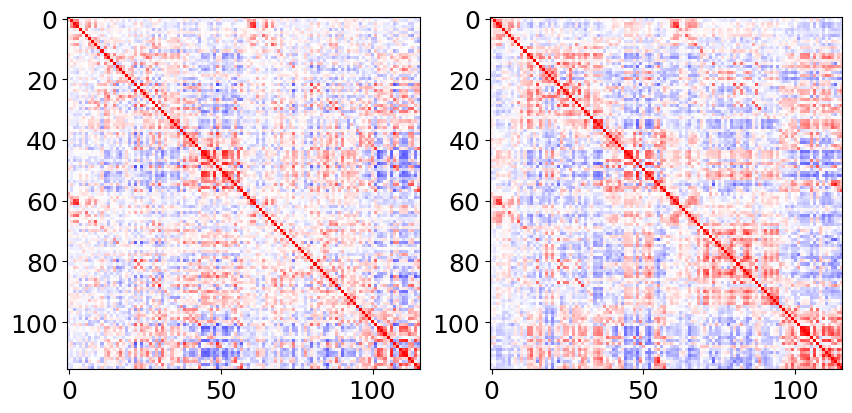

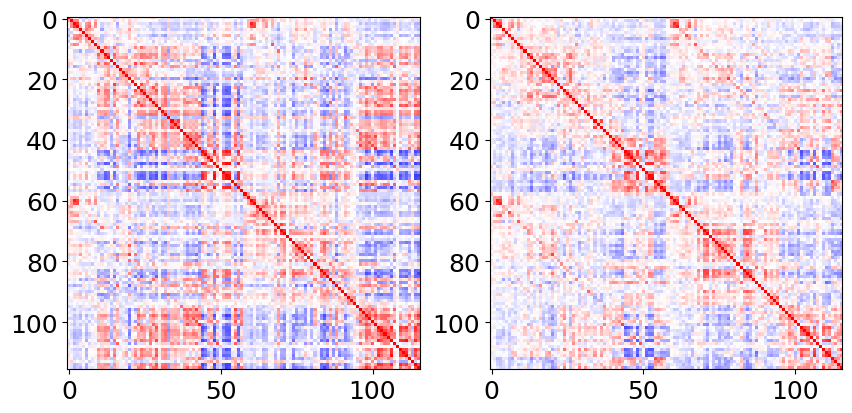

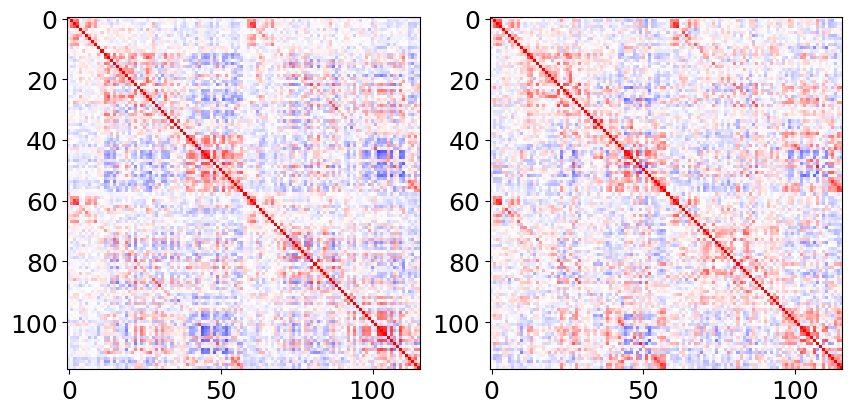

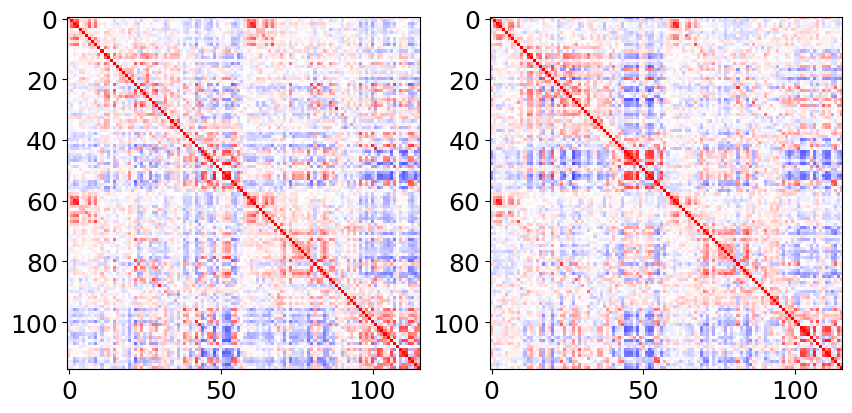

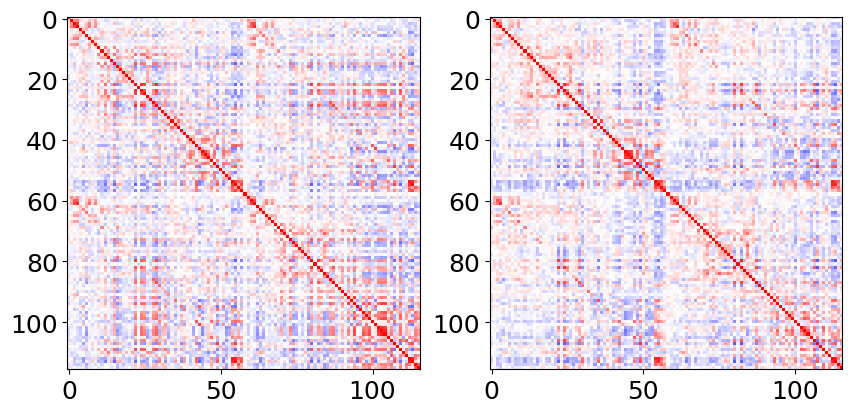

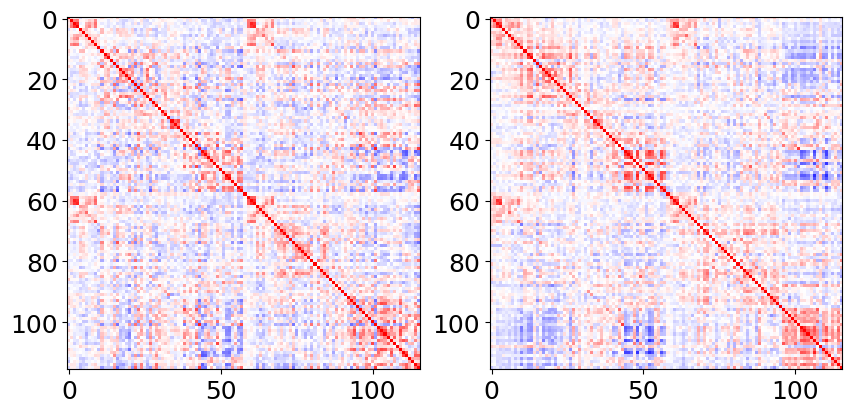

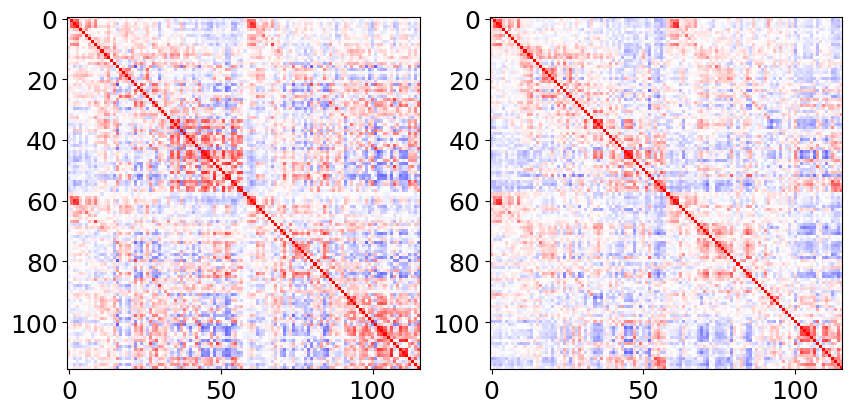

In [23]:
for i in range(len(matrices1)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(matrices1[i], vmin=-1, vmax=1, cmap='bwr')
    ax[1].imshow(matrices2[i], vmin=-1, vmax=1, cmap='bwr')

In [24]:
matrix, most_similar = fingerprint_matrices(np.array(matrices1), np.array(matrices2))

Text(0.5, 0, '7 dpf fish')

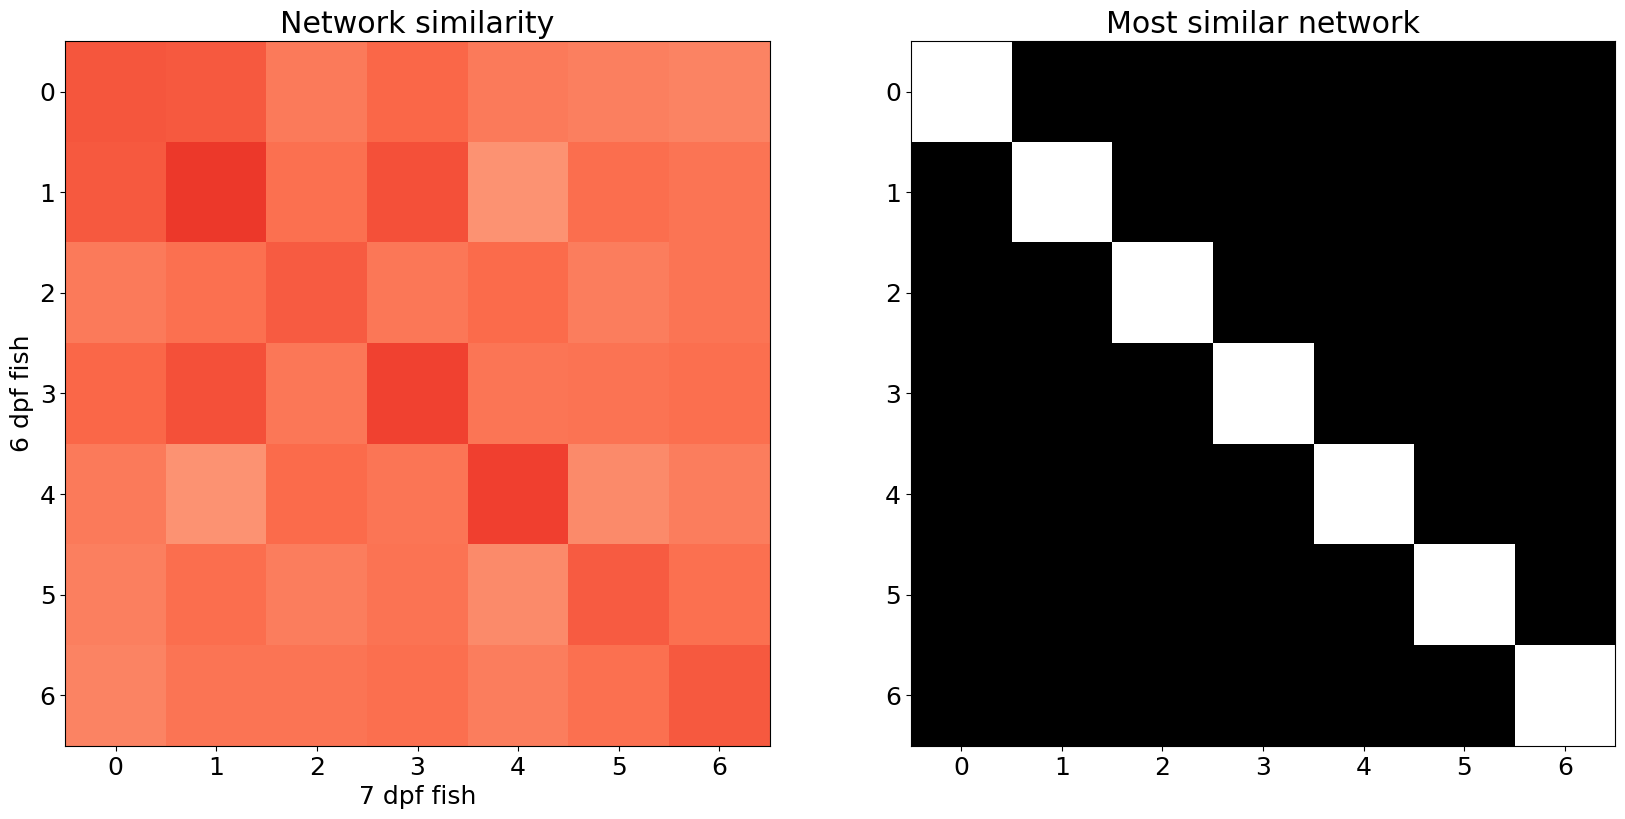

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(0.5 * (matrix + matrix.T), cmap='Reds', vmin=0, vmax=1)
ax[0].set_title('Network similarity')
ax[0].set_ylabel('6 dpf fish')
ax[0].set_xlabel('7 dpf fish')
ax[1].imshow(most_similar, cmap='gray')
ax[1].set_title('Most similar network')
ax[0].set_ylabel('6 dpf fish')
ax[0].set_xlabel('7 dpf fish')

In [26]:
np.save('Results/similarity_GSR.npy', matrix)

### Fingerprinting using static features (control)

In [27]:
avg_fluo = np.load('Results/average_fluo.npy')
std_fluo = np.load('Results/std_fluo.npy')
avg_dff = np.load('Results/average_dff.npy')
std_dff = np.load('Results/std_dff.npy')
noise_raw = np.load('Results/noise_raw.npy')
noise_dff = np.load('Results/noise_dff.npy')

#### Average fluorescence

In [28]:
vectors1 = np.delete(np.stack(avg_fluo[:7], axis=0), excluded, axis=1)
vectors2 = np.delete(np.stack(avg_fluo[7:], axis=0), excluded, axis=1)

In [29]:
matrix, most_similar = fingerprint_vectors(vectors1, vectors2, method='corr')

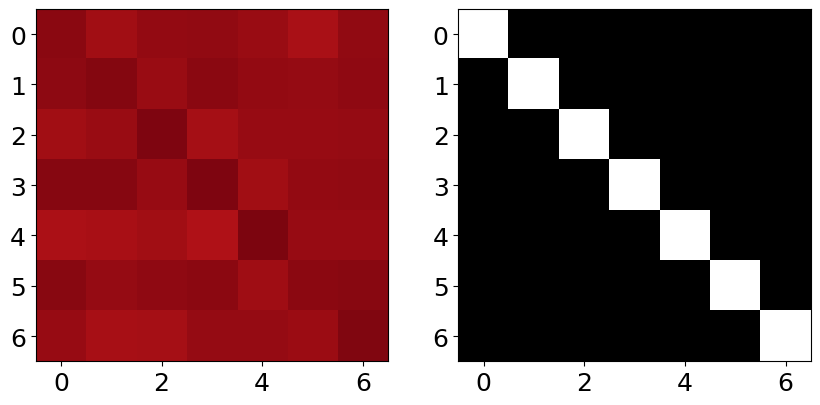

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(matrix, cmap='Reds', vmin=0, vmax=1)
ax[1].imshow(most_similar, cmap='gray')

In [31]:
np.save('Results/similarity_avg_fluo.npy', matrix)

#### Standard deviation fluorescence

In [32]:
vectors1 = np.delete(np.stack(std_fluo[:7], axis=0), excluded, axis=1)
vectors2 = np.delete(np.stack(std_fluo[7:], axis=0), excluded, axis=1)

In [33]:
matrix, most_similar = fingerprint_vectors(vectors1, vectors2, method='corr')

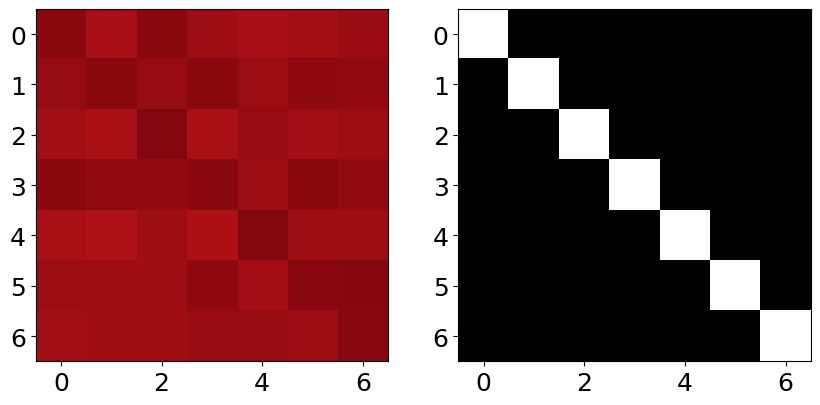

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(matrix, cmap='Reds', vmin=0, vmax=1)
ax[1].imshow(most_similar, cmap='gray')

In [35]:
np.save('Results/similarity_std_fluo.npy', matrix)

### Fingerprinting using z-stack

In [36]:
from calimba.data import *
from calimba.registration import *

In [37]:
def trim_centroids(centroids, stack):
    """Clips an Nx3 array of N centroids so that any coordinates that exceed the atlas volume are brought to the
    volume boundaries. Useful to avoid indexing errors when mapping cells in brain regions."""
    centroids[:, 0] = np.clip(centroids[:, 0], 0, stack.shape[2] - 1)
    centroids[:, 1] = np.clip(centroids[:, 1], 0, stack.shape[1] - 1)
    centroids[:, 2] = np.clip(centroids[:, 2], 0, stack.shape[0] - 1)
    return centroids

In [38]:
directories = ['/home/anleg84/Documents/Valeria/Data/2022-07-26-Wholebrain-6dpf/',
               '/home/anleg84/Documents/Valeria/Data/2022-07-27-Wholebrain-7dpf/']

fishies = ['fish1', 'fish2', 'fish3', 'fish4', 'fish7', 'fish8', 'fish9']

# Data folders
data_folders = []
for d in directories:
    for fish in fishies:
        folder = identify_folders(d, [fish])[0]
        data_folders.append(folder)

# Data folders
registration_folders1 = identify_folders(identify_folders(directories[0], ['Registration-Piezo'])[0])
registration_folders1 = registration_folders1[:4] + registration_folders1[5:]
registration_folders2 = identify_folders(identify_folders(directories[1], ['Registration-Piezo'])[0])
registration_folders = registration_folders1 + registration_folders2

#### Extracting raw fluorescence values at each cell coordinate in the isosbestic stack

In [39]:
raw_fluo = []

for i in tqdm(range(len(data_folders))):
    
    folder = registration_folders[i]
    file = identify_files(folder, ['stack', '.nrrd'], exclude=['aligned'])[0]
    stack, header = load_stack(folder + file)
    dimensions = header['space directions']
    x_size = dimensions[0, 0]
    y_size = dimensions[1, 1]
    z_size = dimensions[2, 2]

    folder = data_folders[i]
    coords = load_coordinates_csv(folder + 'coordinates_stack.csv')
    centroids = np.round(rescale_centroids(coords, [x_size, y_size, z_size])).astype('int')  
    centroids = trim_centroids(centroids, stack)

    values = stack[centroids[:, 2], centroids[:, 1], centroids[:, 0]]
    
    raw_fluo.append(values)

100%|███████████████████████████████████████████| 14/14 [01:27<00:00,  6.27s/it]


#### Averaging these values per region

In [40]:
directories = ['/media/anleg84/KINGSTON/Networks2024/Fingerprinting/6dpf/',
               '/media/anleg84/KINGSTON/Networks2024/Fingerprinting/7dpf/']

fishies = ['fish1', 'fish2', 'fish3', 'fish4', 'fish5', 'fish6', 'fish7']

In [41]:
i = 0
regional_fluo_isosbestic = []

for d in directories:

    for fish in tqdm(fishies):

        folder = d + fish + '/'

        data = load_data(folder)
        centroids = data['centroids_atlas']
        labels = data['region_labels']
        left = centroids[:, 1] <= 284
        right = centroids[:, 1] > 284

        values = np.zeros((140, ))
        for j in range(70):
            region = labels[:, j] > 0
            if np.any(left & region):
                values[j] = np.mean(raw_fluo[i][left & region])
            if np.any(right & region):
                values[j + 70] = np.mean(raw_fluo[i][left & region])

        regional_fluo_isosbestic.append(values)
        i += 1

 14%|██████▍                                      | 1/7 [00:07<00:42,  7.12s/it]/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anleg84/anaconda3/envs/calimba/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████| 7/7 [00:18<00:00,  2.59s/it]


#### Fingerprinting from isosbestic fluo

In [42]:
vectors1 = np.delete(np.stack(regional_fluo_isosbestic[:7], axis=0), excluded, axis=1)
vectors2 = np.delete(np.stack(regional_fluo_isosbestic[7:], axis=0), excluded, axis=1)

In [43]:
matrix, most_similar = fingerprint_vectors(vectors1, vectors2, method='corr')

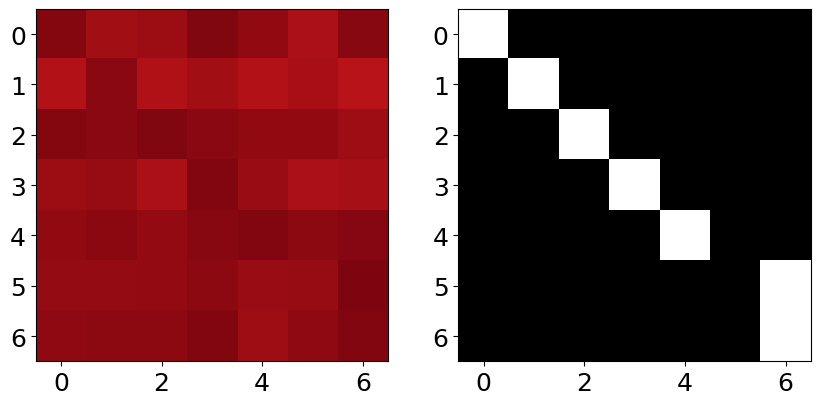

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(matrix, cmap='Reds', vmin=0, vmax=1)
ax[1].imshow(most_similar, cmap='gray')

In [45]:
np.save('Results/similarity_avg_fluo_isosbestic.npy', matrix)

# Part 2: Comparing fingerprinting approaches

In [61]:
from stats import *

In [62]:
matrices = [np.load('Results/similarity_GSR.npy'),
            np.load('Results/similarity_raw.npy'),
            np.load('Results/similarity_avg_fluo.npy'),
            np.load('Results/similarity_std_fluo.npy'),
            np.load('Results/similarity_avg_fluo_isosbestic.npy')
           ]

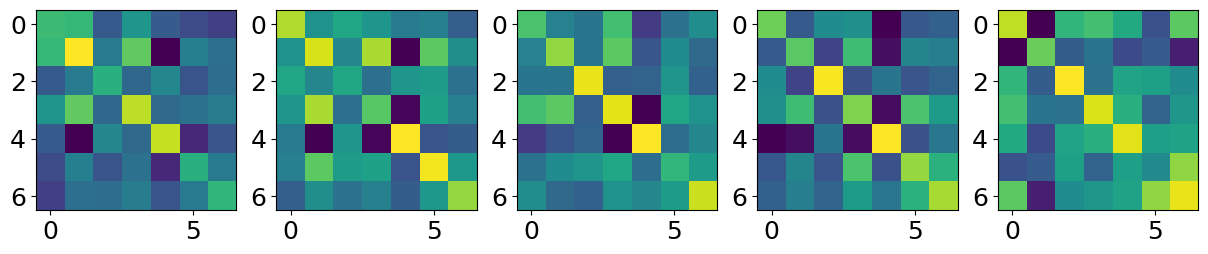

In [63]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(len(matrices)):
    ax[i].imshow(matrices[i] + matrices[i].T)

In [144]:
def get_diag_ratios(matrix):
    diag_values = np.diag(matrix)
    ratios = []
    for i in range(matrix.shape[0]):
        ratios.append(diag_values[i] / np.delete(matrix[i, :], i))
    ratios = np.array(ratios).flatten()
    return ratios.flatten()

In [145]:
diagonals = []
for i in range(len(matrices)):
    diagonals.append(get_diag_ratios(matrices[i]))

Text(0, 0.5, 'Identifyability')

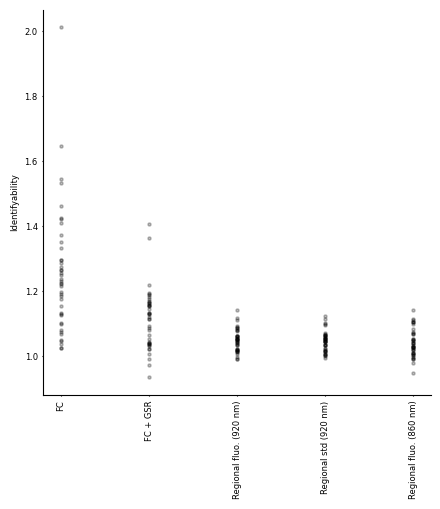

In [146]:
fig, ax = plt.subplots(figsize=(5, 5))
for i, d in enumerate(diagonals):
    plt.scatter([i] * len(d), d, color='black', alpha=0.25, edgecolor=None, s=5)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([0, 1, 2, 3, 4], ['FC', 'FC + GSR', 'Regional fluo. (920 nm)', 'Regional std (920 nm)', 'Regional fluo. (860 nm)'], rotation=90)
ax.set_ylabel('Identifyability')


In [67]:
groups_ANOVA_Tukey(list(diagonals))

ANOVA results: F = 35.48458762370759, p = 1.6282283308276722e-22

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Group 1 Group 2  -0.1405    0.0 -0.2001 -0.0809   True
Group 1 Group 3  -0.2059   -0.0 -0.2655 -0.1464   True
Group 1 Group 4  -0.2093   -0.0 -0.2689 -0.1498   True
Group 1 Group 5  -0.2139   -0.0 -0.2735 -0.1543   True
Group 2 Group 3  -0.0654 0.0234  -0.125 -0.0059   True
Group 2 Group 4  -0.0688 0.0145 -0.1284 -0.0093   True
Group 2 Group 5  -0.0734 0.0074  -0.133 -0.0139   True
Group 3 Group 4  -0.0034 0.9999  -0.063  0.0562  False
Group 3 Group 5   -0.008  0.996 -0.0676  0.0516  False
Group 4 Group 5  -0.0046 0.9995 -0.0642   0.055  False
------------------------------------------------------


### Permutation tests

In [68]:
import itertools

In [83]:
def compute_identification_number(matrix):
    matrix_sym = 0.5 * (matrix + matrix.T)
    diag = np.diag(matrix_sym)
    identifications = np.zeros((len(diag), ))
    for i in range(len(diag)):
        if diag[i] == np.max(matrix_sym[i, :]):
            identifications[i] = 1
    return int(np.sum(identifications))

def compute_permutations(similarity_matrix):
    permutations = list(itertools.permutations(np.arange(similarity_matrix.shape[0])))[1:]
    null_id_rates = []
    for p in tqdm(permutations):
        matrix_shuffled = similarity_matrix[:, np.array(p)]
        rate = compute_identification_number(matrix_shuffled)
        null_id_rates.append(rate)
    return null_id_rates

In [84]:
empirical_identifications = []
for m in matrices:
    empirical_identifications.append(compute_identification_number(m))

In [85]:
print(empirical_identifications)

[7, 6, 7, 7, 6]


In [86]:
null_id_numbers = []
for i in range(len(matrices)):
    null_id_numbers.append(compute_permutations(matrices[i]))

100%|████████████████████████████████████| 5039/5039 [00:00<00:00, 24813.38it/s]


In [100]:
p_values = []

for i, N in enumerate(empirical_identifications):
    N_reproduced = np.sum(np.array(null_id_numbers[i]) == N)  
    p_values.append(N_reproduced / len(null_id_numbers[i]))

In [102]:
p_values

[0.0, 0.00019845207382417147, 0.0, 0.0, 0.0005953562214725144]

# Part 3: Rendering figure

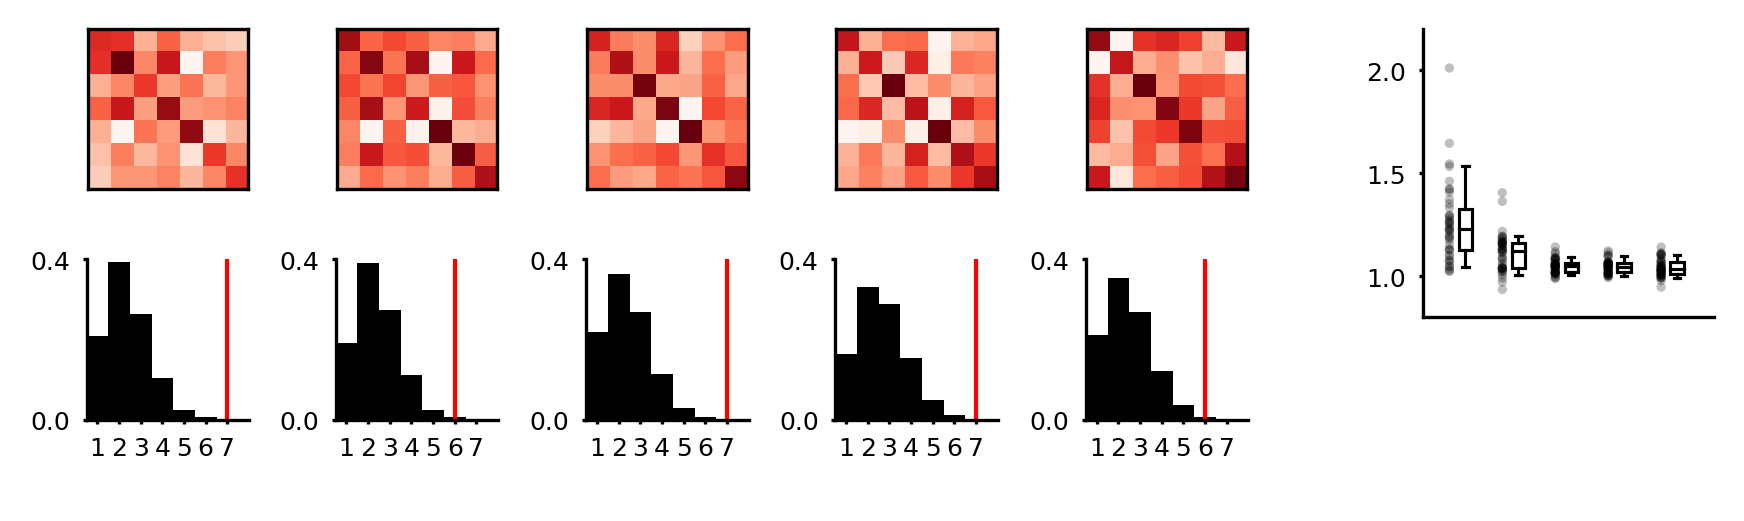

In [155]:
fig = PaperFigure(figsize=(7, 2), dpi=300)

fig.set_tick_length(1)
fig.set_font_size(6)
fig.add_background()

w = 0.7
pad = (5 - 5 * w) / 4

for i in range(len(matrices)):
    fig.add_axes(f'matrix{i}', (i * (w + pad), 0), w, w)
    fig.add_axes(f'hist{i}', (i * (w + pad), 1), w, w)
fig.add_axes('comparison', (5.75, 0), 2, 1.25)

for i in range(len(matrices)):
    ax = fig.axes[f'matrix{i}']
    m = 0.5 * (matrices[i] + matrices[i].T)
    ax.imshow(m, cmap='Reds', vmin=np.min(m), vmax=np.max(m))
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(len(matrices)):
    ax = fig.axes[f'hist{i}']
    bins = np.linspace(-0.5, 7.5, 9, endpoint=True)
    ax.hist(null_id_numbers[i], bins=bins, color='black', density=True)
    ax.axvline(empirical_identifications[i] - 1, color='red', linewidth=1)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])
    ax.set_xlim([-0.5, 7])
    ax.set_ylim([0, 0.4])
    ax.set_yticks([0, 0.4])
    #ax.set_xlabel('Correct identifications')
    #ax.set_ylabel('Null distribution')

ax = fig.axes['comparison']
for i, d in enumerate(diagonals):
    ax.scatter([i] * len(d), d, color='black', alpha=0.25, edgecolor='None', s=5)
    bp = ax.boxplot(d, positions=[i + 0.3], patch_artist=True, widths=0.25, whis=[5, 95])
    set_boxplot_color(bp, color='black', marker='None', linewidth=0.75)

ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim([-0.5, 5])
ax.set_ylim([0.8, 2.2])
ax.set_xticks([])

fig.show()

In [156]:
save_path = '/home/anleg84/Documents/Figures/PaperNetworks2024/Supplementary/'
fig.save(save_path + 'supp_fingerprinting_incomplete.svg')

In [153]:
for m in matrices:
    print((np.min(m), np.max(m)))

(0.31502543988184395, 0.6334415464538234)
(0.5710475968626008, 0.8171831817902828)
(0.8359464488464443, 0.9545329591953541)
(0.8400761711319027, 0.9431954222490248)
(0.812097533895632, 0.9507131835909178)
